# Пережевывая логистическую регрессию 
В этой статье, мы будем разбирать теоретические выкладки преобразования *функции линейной регрессии* в *функцию обратного логит-преобразования (иначе говорят, функцию логистического отклика)*. Затем, воспользовавшись арсеналом *метода максимального правдоподобия*, в соответствии с моделью логистической регрессии, выведем функцию потерь *Logistic Loss*, или другими словами, мы определим функцию, с помощью которой в моделе логистической регрессии подбираются параметры вектора весов $\vec{w}$.

План статьи:

1. Повторим о прямолинейной зависимости между двумя переменными
2. Выявим необходимость преобразования *функции линейной регрессии* $ f(w,x_i) = \vec{w}^T \vec{x_i}$ в *функцию логистического отклика* $ \sigma(\vec{w}^T \vec{x_i}) = \frac{1}{1+e^{-\vec{w}^T \vec{x_i}}} $
3. Проведем преобразования и выведем *функцию логистического отклика*
4. Попытаемся понять, чем плох метод наименьших квадратов при подборе параметров $\vec{w}$ функции *Logistic Loss*
5. Используем *метод максимального правдоподобия* для определения *функции подбора параметров* $\vec{w}$:
    
    5.1. Случай 1: функция *Logistic Loss* для объектов с обозначением классов **0 и 1**:
    
    $ L_{log}(X,\vec{y},\vec{w}) = \sum\limits_{i=1}^n(-y_i \mkern 2mu log_e \mkern 5mu \sigma(\vec{w}^T \vec{x_i}) - 
    (1-y_i) \mkern 2mu log_e \mkern 5mu (1 - \sigma(\vec{w}^T \vec{x_i})) ) \rightarrow min $
    
    5.2. Случай 2: функция *Logistic Loss* для объектов с обозначением классов **-1 и +1**:
    
    $ L_{log}(X,\vec{y},\vec{w}) = \sum\limits_{i=1}^n \mkern 2mu log_e \mkern 5mu (1+e^{-y_i\vec{w}^T\vec{x_i}}) \rightarrow min $

Статья изобилует простыми примерами, в которых все расчеты легко произвести устно или на бумаге, в некоторых случаях может потребоваться калькулятор. Подготовьте :)

Данная статья в большей мере рассчитана на датасайнтистов с начальным уровнем познаний в основах машинного обучения.

В статье также будет приведен код для отрисовки графиков и расчетов. Весь код написан на языке *python 2.7*. Заранее поясню о "новизне" используемой версии - таково одно из условий прохождения известного курса от *Яндекса* на не менее известной интернет-площадке онлайн образования *Coursera*, и, как можно предположить, материал подготовлен по мотивам этого курса.

## 01. Прямолинейная зависимость
Вполне резонно задать вопрос - причем здесь прямолинейная зависимость и логистическая регрессия?
Все просто! Логистическая регрессия представляет собой одну из моделей, которые относятся к линейному классификатору. Простыми словами, задачей линейного классификатора является предсказание целевых значений $y$ от переменных (регрессоров) $X$. При этом считается, что зависимость между признаками $X$ и целевыми значениями $y$ линейная. Отсюда собственно и название классификатора - линейный. Если очень грубо обобщить, то в основе модели логистической регрессии лежит предположение о наличии линейной зависимости между признаками $X$ и целевыми значениями $y$. Вот она - связь.

В студии первый пример, и он, правильно, о прямолинейной зависимости исследуемых величин. В процессе подготовки статьи наткнулся на пример, набивший уже многим оскомину - зависимость силы тока от напряжения *("Прикладной регрессионный анализ", Н.Дрейпер, Г.Смит)*. Здесь мы его тоже рассмотрим. 

В соответствии с *законом Ома:*

$ I = U/R $, где $I$ - сила тока, $U$ - напряжение, $R$ - сопротивление. 

Если бы мы не знали *закон Ома*, то могли бы найти зависимость эмпирически, изменяя $U$ и измеряя $I$, поддерживая при этом $R$ фиксированным. Тогда мы бы увидели, что график зависимости $I$ от $U$ дает более или менее прямую линию, проходящую через начало координат. Мы сказали "более или менее", так как, хотя зависимость фактически точная, наши измерения могут содержать малые ошибки, и поэтому точки на графике, возможно не попадут строго на линию, а будут разбросаны вокруг нее случайным образом.

График 1 "Зависимость $I$ от $U$" 

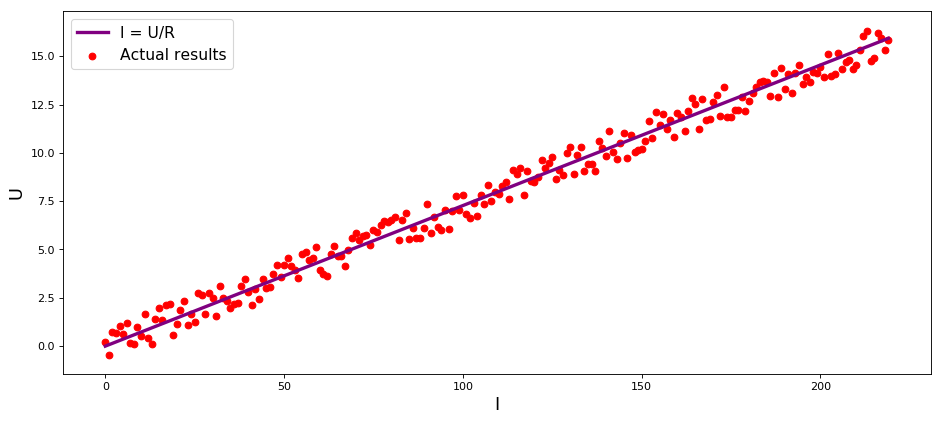

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import random

R = 13.75

x_line = np.arange(0,220,1)
y_line = []
for i in x_line:
    y_line.append(i/R)
    
y_dot = []
for i in y_line:
    y_dot.append(i+random.uniform(-0.9,0.9))


fig, axes = plt.subplots(figsize = (14,6), dpi = 80)
plt.plot(x_line,y_line,color = 'purple',lw = 3, label = 'I = U/R')
plt.scatter(x_line,y_dot,color = 'red', label = 'Actual results')
plt.xlabel('I', size = 16)
plt.ylabel('U', size = 16)
plt.legend(prop = {'size': 14})
plt.show()

Для предсказания $I$ по частным значениям $U$ при фиксированном $R$ мы будем использовать прямую линию. Тогда нашу формулу предсказания для данного случая можно было бы выразить как $I=Uw_1$, где $w_1$ - угловой коэффициент, который заменяет $1/R$ и чем больше $w_1$, тем круче прямая. 

Теперь представим, что прямая может проходить не только через начало координат. В таком случае в уравнение стоит добавить еще один коэффициент, после чего оно примет вид:

$I=w_0 + Uw_1$, 

где $w_0$ - коэффициент, который указывает точку пересечения прямой с осью ординат. 

Обратим внимание, что в нашем случае $w_0$ = 0. 

Вот так просто мы в очередной раз получили объяснение уравнения простой линейной регрессии. 

Не отходите далеко от экранов - в следующем разделе мы узнаем, как это уравнение будет работать в задачах классификации в рамках модели логистической регрессии.

## 02. Необходимость преобразований уравнения линейной регрессии
Рассмотрим очередной пример. Представим, что мы работаем в банке и перед нами задача определить вероятность возврата кредита заемщиком в зависимости от некоторых факторов. Для упрощения задачи, рассмотрим только два фактора: месячная зарплата заемщика и месячный размер платежа на погашение кредита. 

Задача очень условная, но на этом примере мы сможем понять, почему для ее решения недостаточно применения *функции линейной регрессии*, а также узнаем какие преобразования с функцией требуется провести.

Возвращаемся к примеру. Понято, что чем выше зарплата, тем больше заемщик сможет ежемесячно направлять на погашение кредита. При этом, для определенного диапазона зарплат эта зависимость будет вполне себе линейная. Например, возьмем диапазон зарплат от 60.000Р до 200.000Р и предположим, что в указанном диапазоне заработных плат, зависимость размера ежемесячного платежа от размера заработной платы - линейная . Допустим, для указанного диапазона размера заработных плат было выявлено, что соотношение зарплаты к платежу не может опускаться ниже 3 и еще у заемщика должно оставаться в запасе 5.000Р. И только в таком случае, мы будем считать, что заемщик вернет кредит банку. Тогда, уравнение линейной регрессии примет вид:

$f(w,x_i) = w_0 + w_1x_{i1} + w_2x_{i2}$, 

где $w_0 = -5.000$, $w_1 = 1$, $w_2 = -3$, $x_{i1}$ - *зарплата* $i$-го заемщика, $x_{i2}$ - *платеж по кредиту* $i$-го заемщика. 

Подставляя в уравнение зарплату и платеж по кредиту с фиксированными параметрами $\vec{w}$ можно принять решение о выдаче или отказе кредита. 

Забегая вперед, отметим, что, при заданных параметрах $\vec{w}$ *функция линейной регрессии*, применяемая в *функции логистичиеского отклика* будет выдавать большие значения, которые затруднят проведение расчетов по определению вероятностей погашения кредита. Поэтому, предлагается уменьшить наши коэффициенты, скажем так, в 25.000 раз. От этого преобразования в коэффициентах, решение о выдачи кредита не изменится. Запомним этот момент на будущее, а сейчас чтобы было еще понятнее, о чем речь, рассмотрим ситуация с тремя потенциальными заемщиками.

Таблица 1 "Потенциальные заемщики"

In [2]:
import pandas as pd

r = 25000.0
w_0 = -5000.0/r
w_1 = 1.0/r
w_2 = -3.0/r

data = {'The borrower':np.array(['Vasya', 'Fedya', 'Lesha']), 
        'Salary':np.array([120000,180000,210000]),
       'Payment':np.array([3000,50000,70000])}

df = pd.DataFrame(data)

df['f(w,x)'] = w_0 + df['Salary']*w_1 + df['Payment']*w_2

decision = []
for i in df['f(w,x)']:
    if i > 0:
        dec = 'Approved'
        decision.append(dec)
    else:
        dec = 'Refusal'
        decision.append(dec)
        
df['Decision'] = decision

df[['The borrower', 'Salary', 'Payment', 'f(w,x)', 'Decision']]


,The borrower,Salary,Payment,"f(w,x)",Decision
0,Vasya,120000,3000,4.24,Approved
1,Fedya,180000,50000,1.00,Approved
2,Lesha,210000,70000,-0.20,Refusal


В соответствии с данными таблицы, Вася при зарплате в 120.000Р хочет получить такой кредит, чтобы ежемесячного гасить его по 3.000Р. Нами было определено, что для одобрения кредита, размер заработной платы Васи должен превышать в три раза размер платежа, и чтобы еще оставалось 5.000Р. Этому требованию Вася удовлетворяет: $120.000-3*3.000-5.000 = 106.000$. Остается даже 106.000Р. Несмотря на то, что при расчете $f(w,x_i)$ мы уменьшили коэффициенты $\vec{w}$ в 25.000 раз, результат получили тот же - кредит может быть одобрен. Федя тоже получит кредит, а вот Леше, несмотря на то, что он получает больше всех, придется поумерить свои аппетиты.

Нарисуем график по такому случаю.

График 2 "Классификация заемщиков"

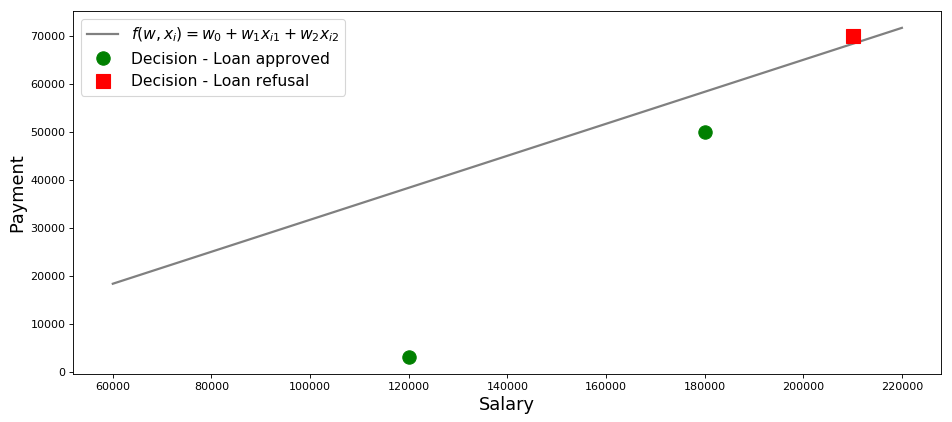

In [3]:
salary = np.arange(60000,240000,20000)
payment = (-w_0-w_1*salary)/w_2


fig, axes = plt.subplots(figsize = (14,6), dpi = 80)
plt.plot(salary, payment, color = 'grey', lw = 2, label = '$f(w,x_i)=w_0 + w_1x_{i1} + w_2x_{i2}$')
plt.plot(df[df['Decision'] == 'Approved']['Salary'], df[df['Decision'] == 'Approved']['Payment'], 
         'o', color ='green', markersize = 12, label = 'Decision - Loan approved')
plt.plot(df[df['Decision'] == 'Refusal']['Salary'], df[df['Decision'] == 'Refusal']['Payment'], 
         's', color = 'red', markersize = 12, label = 'Decision - Loan refusal')
plt.xlabel('Salary', size = 16)
plt.ylabel('Payment', size = 16)
plt.legend(prop = {'size': 14})
plt.show()

Итак, наша прямая, построенная в соответствии с функцией $f(w,x_i) = w_0 + w_1x_{i1} + w_2x_{i2}$, отделяет "плохих" заемщиков от "хороших". Те заемщики, у кого желания не совпадают с возможностями находятся выше прямой (Леша), те же, кто способен согласно параметрам нашей модели, вернуть кредит, находятся под прямой (Вася и Федя). Иначе можно сказать так - наша прямая разделяет заемщиков на два класса. Обозначим их следующим образом: к классу $+1$ отнесем тех заемщиков, которые скорее всего вернут кредит, к классу $-1$ или $0$ отнесем тех заемщиков, которые скорее всего не смогут вернуть кредит. 

Обобщим выводы из этого простенького примера. Возьмем точку $M(x_1,x_2)$ и, подставляя координаты точки в соответствующее уравнение прямой $f(w,x_i) = w_0 + w_1x_{i1} + w_2x_{i2}$, рассмотрим три варианта:

1. Если точка находится под прямой, и мы относим ее к классу $+1$, то значение функции $f(w,x_i) = w_0 + w_1x_{i1} + w_2x_{i2}$ будет положительным от $0$ до $+\infty$. Значит мы можем считать, что вероятность погашения кредита, находится в пределах $(0.5,1]$. Чем больше значение функции, тем выше вероятность.

2. Если точка находится над прямой и мы относим ее к классу $-1$ или $0$, то значение функции будет отрицательным от $0$ до $-\infty$. Тогда мы будем считать, что вероятность погашения задолженности находится в пределах $[0,0.5)$ и, чем больше по модулю значение функции, тем выше наша уверенность.

3. Точка находится на прямой, на границе между двумя классами. В таком случае значение функции $f(w,x_i) = w_0 + w_1x_{i1} + w_2x_{i2}$ будет равно $0$ и вероятность погашения кредита равна $0.5$.

Теперь, представим, что у нас не два фактора, а десятки, заемщиков не три, а тысячи. Тогда вместо прямой у нас будет *m-мерная* плоскость и коэффициенты $w$ у нас будут взяты не с потолка, а выведены по всем правилам, да на основе накопленных данных о заемщиках, вернувших или не вернувших кредит. И действительно, заметьте, мы сейчас отбираем заемщиков при уже известных коэффициентах $w$. На самом же деле, задача модели логистической регрессии как раз и состоит в том, чтобы определить параметры $w$, при которых значение функции потерь *Logistic Loss* будет стремиться к минимальному. Но о том, как рассчитывается вектор $\vec{w}$, мы еще узнаем в 5-м разделе статьи. А пока возвращаемся на землю обетованную - к нашему банкиру и трем его клиентам.

Благодаря функции $f(w,x_i) = w_0 + w_1x_{i1} + w_2x_{i2}$ мы знаем кому можно дать кредит, а кому нужно отказать. Но с такой информацией к директору идти нельзя, ведь от нас хотели получить вероятность возврата кредита каждым заемщиком. Что делать? Ответ простой - нам нужно как-то преобразовать функцию $f(w,x_i) = w_0 + w_1x_{i1} + w_2x_{i2}$, значения которой лежат в диапазоне $(-\infty,+\infty)$ на функцию, значения которой будут лежать в диапазоне $[0,1]$. И такая функция существует, ее называют функцией логистического отклика или обратного-логит преобразования. Знакомьтесь: $ \sigma(\vec{w}^T \vec{x_i}) = \frac{1}{1+e^{-\vec{w}^T \vec{x_i}}} $

Посмотрим по шагам как получается функция логистического отклика. Отметим, что шагать мы будем в обратную сторону, т.е. мы предположим, что нам известно значение вероятности, которое лежит в пределах от $0$ до $1$ и далее мы будем "раскручивать" это значение на всю область чисел от $-\infty$ до $+\infty$.

## 03. Выводим функцию логистического отклика
### Шаг 1. Переведем значения вероятности в диапазон $[0,+\infty)$

На время трансформации функции $f(w,x_i) = w_0 + w_1x_{i1} + w_2x_{i2}$ в функцию логистического отклика $ \sigma(\vec{w}^T \vec{x_i}) = \frac{1}{1+e^{\vec{w}^T \vec{x_i}}} $ мы оставим в покое нашего кредитного аналитика, а вместо этого пройдемся по букмекерским конторам. Нет, конечно, ставки делать мы не будем, все что нас там интересует, так это смысл выражения, например, шанс 4 к 1. Шансы, знакомые всем делающим ставки игрокам, являются соотношением "успехов" к "неуспехам". С точки зрения вероятностей, шансы - это вероятность наступления события, деленая на вероятность того, что событие не произойдет. Запишем формулу шанса наступления события $(odds_+)$:
$$ odds_+ = \frac{p_+}{1-p_+} $$
, где $p_+$ - вероятность наступления события, $(1-p_+)$ - вероятность НЕ наступления события

Например, если вероятность того, что молодой, сильный и резвый конь по прозвищу "Ветерок" обойдет на скачках старую и дряблую старушку по кличке "Матильда" равняется $0.8$, то шансы на успех "Ветерка" составят $4$ к $1$ $(0.8/(1-0.8))$ и наоборот, зная шансы, нам не составит труда вычислить вероятность $p_+$:

$\frac{p_+}{1-p_+} = 4 \mkern 15mu \Longrightarrow \mkern 15mu $ $ p_+=4(1-p_+) \mkern 15mu \Longrightarrow \mkern 15mu $
$ 5p_+=4 \mkern 15mu \Longrightarrow \mkern 15mu $ $ p_+=0.8 $

Таким образом, мы научились "переводить" вероятность в шансы, которые принимают значения от $0$ до $+\infty$. Сделаем еще один шаг и научимся "переводить" вероятность на всю числовую прямую от $-\infty$ до $+\infty$.

### Шаг 2. Переведем значения вероятности в диапазон $(-\infty,+\infty)$
Шаг этот очень простой - прологарифмируем шансы по основанию числа Эйлера $e$ и получим:

$$ f(w,x_i)=\vec{w}^T\vec{x}=ln(odds_+) $$

Теперь мы знаем, что если $p_+=0.8$, то вычислить значение $f(w,x_i)$ будет очень просто и, более того, оно должно быть положительным: $ f(w,x_i)=ln(odds_+)=ln(0.8/0.2)=ln(4) \approx +1.38629 $. Так и есть.

Ради любопытства проверим, что если $p_+=0.2$, тогда мы ожидаем увидеть отрицательное значение $f(w,x_i)$. Проверяем: $f(w,x_i)=ln(0.2/0.8)=ln(0.25) \approx -1.38629$. Все верно.

Теперь мы знаем как перевести значение вероятности от $0$ до $1$ на всю числовую прямую от $-\infty$ до $+\infty)$, в следующем шаге сделаем все наоборот.

А пока, отметим, что в соответствии с правилами логарифмирования, зная значение функции $f(w,x_i)$, можно вычислить шансы: 

$$odds_+ = e^{f(w,x_i)} = e^{\vec{w}^T\vec{x}}$$

Этот способ определения шансов нам пригодится на следующем шаге.

### Шаг 3. Выведем формулу для определения $p_+$
Итак, мы научились, зная $p_+$, находить значения функции $f(w,x_i)$. Однако, на самом деле нам нужно все с точностью до наоборот - зная значение $f(w,x_i)$ находить $p_+$. Для этого обратимся к такому понятию как обратная функция шансов, в соответствии с которой:

$$ p_+ =  \frac{odds_+}{1+odds_+} $$

В статье мы не будем выводить вышеобозначенную формулу, но проверим на цифрах из примера выше. Мы знаем, что при шансах равными 4 к 1 ($odds_+=4$), вероятность наступления события равна 0.8 ($p_+=0.8$). Сделаем подстановку: $p_+=\frac{4}{1+4}=0.8$. Это совпадает с нашими вычислениями, проведенными ранее. Двигаемся далее.

На прошлом шаге мы вывели, что $odds_+ = e^{\vec{w}^T\vec{x}}$, а значит можно сделать замену в обратной функции шансов. Получим:

$ p_+ =  \frac{e^{\vec{w}^T\vec{x}}}{1+e^{\vec{w}^T\vec{x}}} $

Разделим и числитель и знаменатель на $e^{\vec{w}^T\vec{x}}$, тогда:

$ p_+ =  \frac{1}{1+e^{-\vec{w}^T\vec{x}}} = \sigma(\vec{w}^T\vec{x})$

На всякий пожарный, дабы убедиться, что мы нигде не ошиблись, сделаем еще одну небольшую проверку. На шаге 2, мы для $p_+=0.8$ определили, что $f(w,x_i) \approx +1.38629$. Тогда, подставив значение $f(w,x_i)$ в функцию логистического отклика, мы ожидаем получить $p_+=0.8$. Подставляем и получаем: $ p_+=\frac{1}{1+e^{-1.38629}}=0.8 $

Поздравляю вас, уважаемый читатель, мы только что вывели и протестировали функцию логистического отклика. Давайте посмотрим на график функции.

График 3 "Функция логистического отклика"

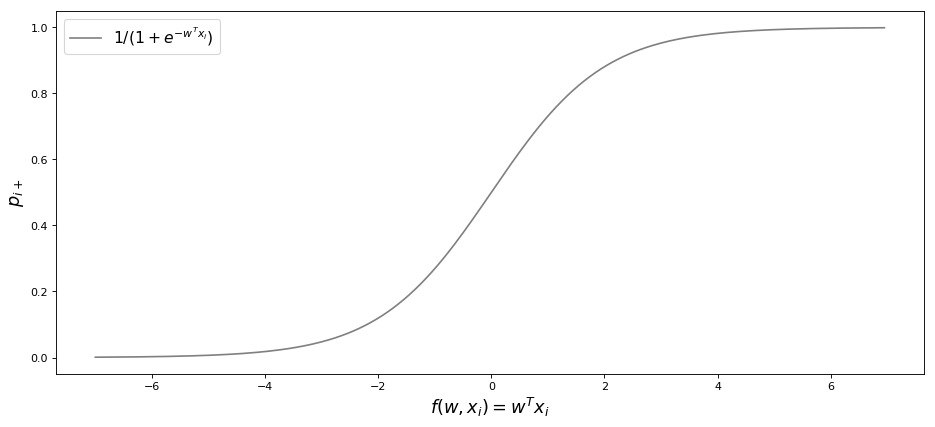

In [4]:
import math

def logit (f):
    return 1/(1+math.exp(-f))

f = np.arange(-7,7,0.05)
p = []

for i in f:
    p.append(logit(i))

fig, axes = plt.subplots(figsize = (14,6), dpi = 80)
plt.plot(f, p, color = 'grey', label = '$ 1 / (1+e^{-w^Tx_i})$')
plt.xlabel('$f(w,x_i) = w^Tx_i$', size = 16)
plt.ylabel('$p_{i+}$', size = 16)
plt.legend(prop = {'size': 14})
plt.show()

В литературе также можно встретить название данной функции как сигмойд-функция. По графику хорошо заметно, что основное изменение вероятности принадлежности объекта к классу происходит на относительно небольшом диапазоне $f(w,x_i)$, где-то от $-4$ до $+4$.

Предлагаю вернуться к нашему кредитному аналитику и помочь ему с вычислением вероятности погашения кредитов, иначе он рискует остаться без премии :)

Таблица 2 "Потенциальные заемщики"

In [5]:
proba = []
for i in df['f(w,x)']:
    proba.append(round(logit(i),2))
    
df['Probability'] = proba

df[['The borrower', 'Salary', 'Payment', 'f(w,x)', 'Decision', 'Probability']]

,The borrower,Salary,Payment,"f(w,x)",Decision,Probability
0,Vasya,120000,3000,4.24,Approved,0.99
1,Fedya,180000,50000,1.00,Approved,0.73
2,Lesha,210000,70000,-0.20,Refusal,0.45


Итак, вероятность возврата кредита мы определили. В целом, это похоже на правду. Действительно, вероятность того что Вася при зарплате в 120.000Р сможет ежемесячно отдавать в банк 3.000Р близка к 100%. Кстати, мы должны понимать, что банк может выдать кредит и Леше в том случае, если политикой банка предусмотрено, например, кредитовать клиентов с вероятностью возврата кредита более, ну скажем, 0.3. Просто в таком случае банк сформирует больший резерв под возможные потери.

Также следует отметить, что соотношение зарплаты к платежу не менее 3 и с запасом в 5.000Р было взято с потолка. Поэтому нам нельзя было использовать в первоначальном виде вектор весов $\vec w = (-5000,1,-3)$. Нам требовалось сильно уменьшить коэффициенты и в таком случае мы разделили каждый коэффициент на 25.000, то есть по сути мы подогнали результат. Но это сделано было специально, чтобы упростить понимание материала на начальном этапе. В жизни, же нам потребуется не выдумывать и подгонять коэффициенты, а находить их. Как раз в следующих разделах статьи мы выведем уравнения, с помощью которых подбираются параметры $\vec{w}$.

## 04. Метод наименьших квадратов при определении вектора весов $\vec{w}$ в функции логистического отклика


Нам уже известен такой метод подбора вектора весов $\vec{w}$, как *метод наименьших квадратов* (*МНК*) и собственно, почему бы нам тогда не использовать его в задачах бинарной классификции? Действительно, ничто не мешает использовать *МНК*, только вот данный способ в задачах классификации дает результаты менее точные, нежели *Logistic Loss*. Этому есть теоретическое обоснование. Давайте для начала посмотрим на один простой пример.

Предположим, что наши модели (*MSE* и *Logistic Loss*) уже начали подбор вектора весов $\vec{w}$ и мы остановили расчет на каком-то шаге. Неважно, в середине, в конце или в начале, главное, что у нас уже есть какие-то значения вектора весов и допустим, что на этом шаге, вектора весов $\vec{w}$ для обеих моделей не имеют различий. Тогда возьмем полученные веса и подставим их в функцию логистического отклика ($ \frac{1}{1+e^{-\vec{w}^T\vec{x}}}$) для какого-нибудь объекта, который относится к классу $+1$. Исследуем два случая, когда в соответствии с подобранным вектором весов наша модель сильно ошибается и наоборот - модель сильно уверена в том, что объект относится к классу $+1$. Посмотрим какие штрафы будут "выписаны" при использовании *МНК* и *Logistic Loss*.

In [6]:
# класс объекта
y = 1
# вероятность отнесения объекта к классу в соответствии с параметрами w
proba_1 = 0.01

MSE_1 = (y - proba_1)**2
print 'Штраф MSE при грубой ошибке =', MSE_1

# напишем функцию для вычисления f(w,x) при известной вероятности отнесения объекта к классу +1 (f(w,x)=ln(odds+))
def f_w_x(proba):
    return math.log(proba/(1-proba)) 

LogLoss_1 = math.log(1+math.exp(-y*f_w_x(proba_1)))
print 'Штраф Log Loss при грубой ошибке =', LogLoss_1

proba_2 = 0.99

MSE_2 = (y - proba_2)**2
LogLoss_2 = math.log(1+math.exp(-y*f_w_x(proba_2)))

print '**************************************************************'
print 'Штраф MSE при сильной уверенности =', MSE_2
print 'Штраф Log Loss при сильной уверенности =', LogLoss_2

Штраф MSE при грубой ошибке = 0.9801
Штраф Log Loss при грубой ошибке = 4.60517018599
**************************************************************
Штраф MSE при сильной уверенности = 0.0001
Штраф Log Loss при сильной уверенности = 0.0100503358535


**Случай с грубой ошибкой** - модель относит объект к классу $+1$ с вероятностью в 0,01

Штраф при использовании *МНК* составит: $MSE = (y - p_+) = (1-0.01)^2 = 0.9801$

Штраф при использовании *Logistic Loss* составит: $Log Loss = log_e(1+e^{-yf(w,x)}) = log_e(1+e^{-1(-4.595...)}) \approx 4.605$

**Случай с сильной уверенностью** - модель относит объект к классу $+1$ с вероятностью в 0,99

Штраф при использовании *МНК* составит: $MSE = (1-0.99)^2 = 0.0001$

Штраф при использовании *Logistic Loss* составит: $Log Loss = log_e(1+e^{-4.595...}) \approx 0.01 $

Этот пример хорошо иллюстрирует, что при грубой ошибке функция потерь *Log Loss* штрафует модель значительно сильнее, чем *MSE*. Давайте теперь разберемся, каковы теоретические предпосылки использования функции потерь *Log Loss* в задачах классификации.

## 05. Метод максимального правдоподобия и логистическая регрессия

Как и было обещано в начале, статья изобилует простыми примерами. В студии очередной пример и старые гости - заемщики банка: Вася, Федя и Леша. 

На всякий пожарный, перед тем как развивать пример, напомню, что в жизни мы имеем дело с обучающей выборкой из тысяч или миллионов объектов с десятками или сотнями признаков. Однако здесь цифры взяты так, чтобы они легко укладывались в голове начинающего датасайнтеста. 

Возвращаемся к примеру. Представим, что директор банка решил выдать кредит всем нуждающимся, несмотря на то, что алгоритм подсказывал не выдавать его Леше. И вот прошло достаточно времени и нам стало известно кто из трех героев погасил кредит, а кто нет. Что и следовало ожидать: Вася и Федя погасили кредит, а Леша - нет. Теперь давайте представим, что этот результат будет для нас новой обучающей выборкой и, при этом у нас как будто исчезли все данные о факторах, влияющих на вероятность погашения кредита (зарплата заемщика, размер ежемесячного платежа). Тогда интуитивно мы можем полагать, что каждый третий заемщик не возвращает банку кредит или другими словами вероятность возврата кредита следующим заемщиком $p=\frac{2}{3}$. Этому интуитивному предположению есть теоретическое подтверждение и основывается оно на *методе максимального правдоподобия*, часто в литературе его называют *принципом максимального правдоподобия*.

Для начала познакомимся с понятийным аппаратом.

*Правдоподобие выборки* - это вероятность получения именно такой выборки, получения именно таких наблюдений / результатов, т.е. произведение вероятностей получения каждого из результатов выборки (например, погашен или не погашен кредит Васей, Федей и Лешей одновременно). 

*Функция правдоподобия* связывает правдоподобие выборки со значениями параметров распределения. 

В нашем случае, обучающая выборка представляет собой обобщённую схему Бернулли, в которой случайная величина принимает всего два значения: $1$ или $0$.  Следовательно, правдоподобие выборки можно записать как функцию правдоподобия от параметра $p$ следующим образом:

$P(\mkern 5mu \vec{y} \mkern 5mu |\mkern 5mu p) = \prod\limits_{i=1}^3 p^{y_i} (1-p)^{(1-y_i)} \mkern 5mu = \mkern 5mu
p^1(1-p)^{1-1} \centerdot p^1(1-p)^{1-1} \centerdot p^0(1-p)^{1-0} \mkern 5mu = \mkern 5mu
p \centerdot p \centerdot (1-p) \mkern 5mu = \mkern 5mu p^2(1-p)$

Вышеуказанную запись можно интерпретировать так. Совместная вероятность того, что Вася и Федя погасят кредит равна $p \centerdot p = p^2$, вероятность того что Леша НЕ погасит кредит равна $1-p$ (так как имело место именно НЕ погашение кредита), следовательно совместная вероятность всех трех событий равна $p^2(1-p)$ .

*Метод максимального правдоподобия* - это метод оценивания неизвестного параметра путём максимизации функции правдоподобия. В нашем случае требуется найти такое значение $p$, при котором $P(\mkern 5mu \vec{y} \mkern 5mu |\mkern 5mu p) = p^2(1-p)$ достигает максимума. 

Откуда собственно идея – искать значение неизвестного параметра, при котором функция правдоподобия достигает максимума? Истоки идеи проистекают из представления о том, что выборка – это единственный, доступный нам, источник знания о генеральной совокупности. Все, что нам известно о генеральной совокупности, представлено в выборке. Поэтому, все, что мы можем сказать, так это то, что выборка – это наиболее точное отражение генеральной совокупности, доступное нам. Следовательно, нам требуется найти такой параметр, при котором имеющаяся выборка становится наиболее вероятной.

Очевидно, мы имеем дело с оптимизационной задачей, в которой требуется найти точку экстремума функции. Для нахождения точки экстремума необходимо рассмотреть условие первого порядка, то есть приравнять производную функции к нулю и решить уравнение относительно искомого параметра. Однако поиски производной произведения большого количества множителей могут оказаться делом затяжным, чтобы этого избежать существует специальный прием - переход к логарифму *функции правдоподобия*. Почему возможен такой переход? Обратим внимание на то, что мы ищем не сам экстремум функции $P(\mkern 5mu \vec{y} \mkern 5mu |\mkern 5mu p)$, а точку экстремума, то есть то значение неизвестного параметра $p$, при котором $P(\mkern 5mu \vec{y} \mkern 5mu |\mkern 5mu p)$ достигает максимума. При переходе к логарифму точка экстремума не меняется (хотя сам экстремум будет отличаться), так как логарифм - монотонная функция.

Давайте, в соответствии с вышеизложенным, продолжим развивать наш пример с кредитами у Васи, Феди и Леши. Для начала перейдем к логарифму *функции правдоподобия*:

$logP(\mkern 5mu \vec{y} \mkern 5mu |\mkern 5mu p) \mkern 5mu = \mkern 5mu logp^2(1-p) \mkern 5mu = \mkern 5mu 2logp + log(1-p)$

Теперь мы можем с легкостью продифференцировать выражение по $p$:

$\frac{\partial logP(\mkern 5mu \vec{y} \mkern 5mu |\mkern 5mu p)}{\partial p} \mkern 5mu = \mkern 5mu 
\frac{\partial}{\partial p} (2logp + log(1-p)) \mkern 5mu = \mkern 5mu \frac{2}{p} - \frac{1}{1-p}$

И наконец, рассмотрим условие первого порядка - приравняем производную функции к нулю:

$ \frac{2}{p} - \frac{1}{1-p} = 0 \mkern 5mu \Longrightarrow \mkern 5mu \frac{2}{p} = \frac{1}{1-p}
\mkern 5mu \Longrightarrow \mkern 5mu 2(1-p) = p \mkern 5mu \Longrightarrow \mkern 5mu p = \frac{2}{3} $

Таким образом, наша интуитивная оценка вероятности погашения кредита $p = \frac{2}{3}$ была теоретически обоснована.

Отлично, но что нам теперь делать с такой информацией? Если мы будем считать, что каждый третий заемщик не вернет банку деньги, то последний неизбежно разорится. Так-то оно так, да только при оценке вероятности погашения кредита равной $\frac{2}{3}$ мы не учли факторы, влияющие на возврат кредита: заработная плата заемщика и размер ежемесячного платежа. Вспомним, что ранее мы рассчитали вероятность возврата кредита каждым клиентом с учетом этих самых факторов. Логично, что и вероятности у нас получились отличные от константы равной $\frac{2}{3}$.


Давайте определим правдоподобие выборок:

In [7]:
from functools import reduce

def likelihood(y,p):
    line_true_proba = []
    for i in range(len(y)):
        ltp_i = p[i]**y[i]*(1-p[i])**(1-y[i])
        line_true_proba.append(ltp_i)
    likelihood = []
    return reduce(lambda a, b: a*b, line_true_proba)
        
    
y = [1.0,1.0,0.0]
p_log_response = df['Probability']
const = 2.0/3.0
p_const = [const, const, const]


print 'Правдоподобие выборки при константном значении p=2/3:', round(likelihood(y,p_const),3)

print '****************************************************************************************************'

print 'Правдоподобие выборки при расчетном значении p:', round(likelihood(y,p_log_response),3)

Правдоподобие выборки при константном значении p=2/3: 0.148
****************************************************************************************************
Правдоподобие выборки при расчетном значении p: 0.397


*Правдоподобие выборки при константном значении $p=\frac{2}{3}$*:

$P(\mkern 5mu \vec{y} \mkern 5mu |\mkern 5mu p) \mkern 5mu = \mkern 5mu p^2(1-p)
\mkern 5mu = \mkern 5mu \frac{2}{3}^2(1-\frac{2}{3}) \mkern 5mu \approx \mkern 5mu 0.148  $

*Правдоподобие выборки при расчете вероятности погашения кредита с учетом факторов $\vec{x}$*:

$ P(\mkern 5mu \vec{y} \mkern 5mu |\mkern 5mu p) = \prod\limits_{i=1}^3 p^{y_i} (1-p)^{(1-y_i)} \mkern 5mu = \mkern 5mu
p_1^1(1-p_1)^{1-1} \centerdot p_2^1(1-p_2)^{1-1} \centerdot p_3^0(1-p_3)^{1-0} \mkern 5mu = \mkern 5mu
p_1 \centerdot p_2 \centerdot (1-p_3) \mkern 5mu = \mkern 5mu 0.99 \centerdot 0.73 \centerdot (1-0.45) 
\mkern 5mu \approx \mkern 5mu 0.397 $

Правдоподобие выборки с вероятностью, посчитанной в зависимости от факторов оказалось выше правдоподобия при константном значении вероятности. О чем это говорит? Это говорит о том, что знания о факторах позволили подобрать более точно вероятность погашения кредита для каждого клиента. Поэтому, при выдаче очередного кредита, правильнее будет использовать, предложенную в конце 3-го раздела статьи, модель оценки вероятности погашения задолженности. 

Но тогда, если нам требуется максимизировать *функцию правдоподобия выборки*, то почему бы не использовать какой-нибудь алгоритм, который будет выдавать вероятности для Васи, Феди и Леши, например, равными 0.99, 0.99 и 0.01 соответственно. Возможно такой алгоритм и хорошо себя проявит на обучающей выборке, так как приблизит значение правдоподобия выборки к $1$, но, во-первых, у такого алгоритма будут, скорее всего трудности с обобщающей способностью, во-вторых, этот алгоритм будет точно не линейным. И если, методы борьбы с переобучением (равно слабая обобщающая способность) явно не входят в план этой статьи, то по второму пункту давайте пройдемся подробнее. Для этого, достаточно ответить на простой вопрос. Может ли вероятность погашения кредита Васей и Федей быть одинаковой с учетом известных нам факторов? С точки зрения здравой логики конечно же нет, не может. Так на погашение кредита Вася будет отдавать 2.5% своей зарплаты в месяц, а Федя - почти 27,8%. Также на графике 2 "Классификация клиентов" мы видим, что Вася находится значительно дальше от линии, разделяющей классы, чем Федя. Ну и наконец, мы знаем, что функция $f(w,x) = w_0 + w_1x_1 + w_2x_2$ для Васи и Феди принимает различные значения: 4.24 для Васи и 1.0 для Феди. Вот если бы Федя, например, зарабатывал на порядок больше или кредит поменьше просил, то тогда вероятности погашения кредита у Васи и Феди были бы схожими. Другими словами, линейную зависимость не обманешь. И если бы мы действительно рассчитали коэффициенты $w$, а не взяли их с потолка, то могли бы смело заявить, что наши значения $w$ лучше всего позволяют оценить вероятность погашения кредита каждым заемщиком, но так как мы условились считать, что определение коэффициентов $w$ было проведено по всем правилам, то мы так и будем считать - наши коэффициенты позволяют дать лучшую оценку вероятности :)

Однако мы отвлеклись. В этом разделе нам надо разобраться как определяется вектор весов $\vec{w}$, который необходим для оценки вероятности возврата кредита каждым заемщиком. 

Кратко резюмируем, с каким арсеналом мы выступаем на поиски коэффициентов $w$:

1. Мы предполагаем, что зависимость между целевой переменной (прогнозным значением) и фактором, оказывающим влияние на результат - линейная. По этой причине применяется *функция линейной регрессии* вида  $f(w,x) = \vec{w}^TX$, линия которого делит объекты (клиентов) на классы $+1$ и $-1$ или $0$ (клиенты, способные погасить кредит и не способные). В нашем случае уравнение имеет вид $f(w,x) = w_0 + w_1x_1 + w_2x_2$.

2. Мы используем *функцию обратного логит-преобразования* вида $ p_+ =  \frac{1}{1+e^{-\vec{w}^T\vec{x}}} = \sigma(\vec{w}^T\vec{x})$ для определения вероятности принадлежности объекта к классу $+1$.

3. Мы рассматриваем нашу обучающую выборку как реализацию обобщенной *схемы Бернулли*, то есть для каждого объекта генерируется случайная величина, которая с вероятностью $p$ (своей для каждого объекта) принимает значение 1 и с вероятностью $(1–p)$ – 0.

4. Мы знаем, что нам требуется максимизировать *функцию правдоподобия выборки* с учетом принятых факторов для того, чтобы имеющаяся выборка стала наиболее правдоподобной. Другими словами, нам нужно подобрать такие параметры, при которых выборка будет наиболее правдоподобной. В нашем случае подбираемый параметр - это вероятность погашения кредита $p$, которая в свою очередь зависит от неизвестных коэффициентов $w$. Значит нам требуется найти такой вектор весов $\vec{w}$, при котором правдоподобие выборки будет максимальным.

5. Мы знаем, что для максимизации *функции правдоподобия выборки* можно использовать *метод максимального правдоподобия*. И мы знаем все хитрые приемы для работы с этим методом.

Вот такая многоходовочка получается :)

А теперь вспомним, что в самом начале статьи мы хотели вывести два вида функции потерь *Logistic Loss* в зависимости от того как обозначаются классы объектов. Так повелось, что в задачах классификации с двумя классами, классы обозначают как $+1$ и $0$ или $-1$. В зависимости от обозначения, на выходе будет соответствующая функция потерь.

### Случай 1. Классификация объектов на $+1$ и $0$

Раннее, при определении правдоподобия выборки, в котором вероятность погашения задолженности заемщиком рассчитывалась исходя из факторов и заданных коэффициентов $w$, мы применили формулу:

$ P(\mkern 5mu \vec{y} \mkern 5mu |\mkern 5mu p) = \prod\limits_{i=1}^3 p^{y_i} (1-p)^{(1-y_i)}$

На самом деле $p_i$ - это значение функции логистического отклика $ p_+ =  \frac{1}{1+e^{-\vec{w}^T\vec{x}}} = \sigma(\vec{w}^T\vec{x})$ при заданном векторе весов $\vec{w}$

Тогда нам ничто не мешает записать функцию правдоподобия выборки так:

$ P(\mkern 5mu \vec{y} \mkern 5mu |\mkern 5mu \sigma(\vec{w}^TX)) \mkern 5mu = \mkern 5mu
\prod\limits_{i=1}^n \sigma(\vec{w}^T\vec{x_i})^{y_i} \mkern 10mu (1-\sigma(\vec{w}^T\vec{x_i})^{(1-y_i)} 
\mkern 10mu \rightarrow \mkern 10mu max $

Бывает так, что иногда, некоторым начинающим аналитикам сложно сходу понять, как эта функция работает. Давайте рассмотрим 4 коротких примера, которые все прояснят:

1. Если $y_i = +1$ (т.е. в соответствии с обучающей выборкой объект относится к классу +1), а наш алгоритм $\sigma(\vec{w}^TX))$ определяет вероятность отнесения объекта к классу $+1$ равной 0.9, то вот этот кусочек правдоподобия выборки будет рассчитываться так:

$0.9^1 \centerdot (1-0.9)^{(1-1)}= 0.9^1 \centerdot 0.1^0 = 0.9$

2. Если $y_i = +1$, а $\sigma(\vec{w}^TX)) = 0.1$, то расчет будет таким:

$0.1^1 \centerdot (1-0.1)^{(1-1)}= 0.1^1 \centerdot 0.9^0 = 0.1$

3. Если $y_i = 0$, а $\sigma(\vec{w}^TX)) = 0.1$, то расчет будет таким:

$0.1^0 \centerdot (1-0.1)^{(1-0)}= 0.1^0 \centerdot 0.9^1 = 0.9$

4. Если $y_i = 0$, а $\sigma(\vec{w}^TX)) = 0.9$, то расчет будет таким:

$0.9^0 \centerdot (1-0.9)^{(1-0)}= 0.9^0 \centerdot 0.1^1 = 0.1$

Очевидно, что функция правдоподобия будет максимизироваться в случаях 1 и 3 или в общем случае - при правильно отгаданных значениях вероятностей отнесения объекта к классу $+1$.

В связи с тем, что при определении вероятности отнесения объекта к классу $+1$ нам не известны только коэффициенты $w$, то мы их и будем искать. Как и говорилось выше, это задача оптимизации, в которой для начала нам требуется найти производную от функции правдоподобия по вектору весов $w$. Однако предварительно имеет смысл упростить себе задачу: производную будем искать от логарифма функции правдоподобия.

$ L_{log}(X,\vec{y},\vec{w}) = \sum\limits_{i=1}^n(-y_i \mkern 2mu log_e \mkern 5mu \sigma(\vec{w}^T \vec{x_i}) - 
    (1-y_i) \mkern 2mu log_e \mkern 5mu (1 - \sigma(\vec{w}^T \vec{x_i})) ) \rightarrow min $
    
Почему после логарифмирования, в функции логистической ошибки, мы поменяли знак с $+$ на $-$. Все просто, так как в задачах оценки качества модели принято минимизировать значение функции, то мы умножили правую часть выражения на $-1$ и соответственно вместо максимизации, теперь минимизируем функцию.

Собственно, сейчас, на ваших глазах была много страдальчески выведена функция потерь - *Logistic Loss* для обучающей выборки с двумя классами: $+1$ и $0$.

Теперь, для нахождения коэффициентов, нам потребуется всего лишь найти производную функции логистической ошибки и далее, используя численные методы оптимизации, такие как градиентный спуск или стохастический градиентный спуск, подобрать наиболее оптимальные коэффициенты $w$. Но, учитывая, уже не малый объем статьи, предлагается провести дифференцирование самостоятельно или, быть может, это будет темой для следующей статьи с большим количеством арифметики без столь подробных примеров.

### Случай 2. Классификация объектов на $+1$ и $-1$

Подход здесь будет такой же, как и с классами $1$ и $0$, но сама дорожка к выводу функции логистической ошибки, будет более витиеватой. Приступаем. Будем для функции правдоподобия использовать оператор *"если..., то..."*. То есть, если $i$-ый объект относится к классу $+1$, то для расчета правдоподобия выборки используем вероятность $p$, если объект относится к классу $-1$, то в правдоподобие подставляем $(1-p)$. Вот так выглядит функция правдоподобия:

$ P(\mkern 5mu \vec{y} \mkern 5mu |\mkern 5mu \sigma(\vec{w}^TX)) \mkern 5mu = \mkern 5mu
\prod\limits_{i=1}^n \sigma(\vec{w}^T\vec{x_i})^{[y_i=+1]} \mkern 10mu (1-\sigma(\vec{w}^T\vec{x_i})^{[y_i=-1])} 
\mkern 10mu \rightarrow \mkern 10mu max $

На пальцах распишем как это работает. Рассмотрим 4 случая:

1. Если $y_i=+1$ и $\sigma(\vec{w}^T\vec{x_i})=0.9$, то в правдоподобие выборки "пойдет" $0.9$

2. Если $y_i=+1$ и $\sigma(\vec{w}^T\vec{x_i})=0.1$, то в правдоподобие выборки "пойдет" $0.1$

3. Если $y_i=-1$ и $\sigma(\vec{w}^T\vec{x_i})=0.1$, то в правдоподобие выборки "пойдет" $1-0.1=0.9$

4. Если $y_i=-1$ и $\sigma(\vec{w}^T\vec{x_i})=0.9$, то в правдоподобие выборки "пойдет" $1-0.9=0.1$

Очевидно, что в 1 и 3 случае, когда вероятности были правильно определены алгоритмом, функция правдоподобия будет максимизироваться, то есть именно это мы и хотели получить. Однако, такой подход достаточно громоздок и далее мы рассмотрим более компактную запись. Но для начала, логарифмируем функцию правдоподобия с заменой знака, так как теперь мы будем минимизировать ее.

$ L_{log}(X,\vec{y},\vec{w}) = \sum\limits_{i=1}^n(-[y_i=+1] \mkern 2mu log_e \mkern 5mu \sigma(\vec{w}^T \vec{x_i}) - 
    [y_i=-1] \mkern 2mu log_e \mkern 5mu (1 - \sigma(\vec{w}^T \vec{x_i})) ) \rightarrow min $
    
Подставим вместо $\sigma(\vec{w}^T \vec{x_i})$ выражение $\frac{1}{1+e^{-\vec{w}^T\vec{x_i}}}$:

$ L_{log}(X,\vec{y},\vec{w}) = \sum\limits_{i=1}^n(-[y_i=+1] \mkern 2mu log_e \mkern 5mu (\frac{1}{1+e^{-\vec{w}^T\vec{x_i}}}) - 
    [y_i=-1] \mkern 2mu log_e \mkern 5mu (1 - \frac{1}{1+e^{-\vec{w}^T\vec{x_i}}})) \rightarrow min $
    
Упростим правое слагаемое под логарифмом, используя простые арифметические приемы и получим:

$ L_{log}(X,\vec{y},\vec{w}) = \sum\limits_{i=1}^n(-[y_i=+1] \mkern 2mu log_e \mkern 5mu (\frac{1}{1+e^{-\vec{w}^T\vec{x_i}}}) - 
    [y_i=-1] \mkern 2mu log_e \mkern 5mu (\frac{1}{1+e^{\vec{w}^T\vec{x_i}}})) \rightarrow min $
    
    
А теперь настало время избавиться от оператора *"если..., то..."*. Заметим, что когда объект $y_i$ относится к классу $+1$, то в выражении под логарифмом, в знаменателе, $e$ возводится в степень $-\vec{w}^T\vec{x_i}$, если объект относится к классу $-1$, то $e$ возводится в степень $+\vec{w}^T\vec{x_i}$. Следовательно запись степени можно упростить - объединить оба случая в один: $-y_i\vec{w}^T\vec{x_i}$. Тогда функция логистической ошибки примет вид:

$ L_{log}(X,\vec{y},\vec{w}) = \sum\limits_{i=1}^n- \mkern 2mu log_e \mkern 5mu (\frac{1}{1+e^{-y_i\vec{w}^T\vec{x_i}}} ) \rightarrow min $

В соответствии с правилами логарифмирования, перевернем дробь и вынесем знак "$-$" (минус) за логарифм, получим:

$ L_{log}(X,\vec{y},\vec{w}) = \sum\limits_{i=1}^n \mkern 2mu log_e \mkern 5mu (1+e^{-y_i\vec{w}^T\vec{x_i}}) \rightarrow min $

Перед вами функция потерь *logistic Loss*, которая применяется обучающей выборке с объектами относящихся к классам: $+1$ и $-1$. 

Что ж, на этом моменте завершим статью.

## Вспомогательные материалы

#### 1. Литература
1) Прикладной регрессионный анализ / Н. Дрейпер, Г. Смит – 2-е изд. – М.: Финансы и статистика, 1986 (перевод с английского)

2) Теория вероятностей и математическая статистика / В.Е. Гмурман - 9-е изд. - М.:Высшая школа, 2003

3) Теория вероятностей / Н.И. Чернова - Новосибирск: Новосибирский государственный университет, 2007

4) Бизнес-аналитика: от данных к знаниям / Паклин Н. Б., Орешков В. И. - 2-е изд. - Санкт-Петербург: Питер, 2013

5) Data Science Наука о данных с нуля / Джоэл Грас - Санкт-Петербург: БХВ Петербург, 2017

6) Практическая статистика для специалистов Data Science / П.Брюс, Э.Брюс - Санкт-Петербург: БХВ Петербург, 2018

#### 2. Лекции, курсы (видео)

1) Суть метода максимального правдоподобия, Борис Демешев:

https://www.youtube.com/watch?v=2iRIqkm1mug

2) Метод максимального правдоподобия в непрерывном случае, Борис Демешев:

https://www.youtube.com/watch?v=9CeB32vxM0A

3) Логистическая регрессия. Открытый курс ODS, Yury Kashnitsky

https://www.youtube.com/watch?v=NO4KSNbsXZE

4) Лекция 4, Евгений Соколов (с 47 минуты видео)

https://www.youtube.com/watch?v=PrsLyrz7Zlw&list=PLEqoHzpnmTfDwuwrFHWVHdr1-qJsfqCUX&index=3

5) Логистическая регрессия, Вячеслав Воронцов

https://www.coursera.org/lecture/vvedenie-mashinnoe-obuchenie/loghistichieskaia-rieghriessiia-8G3Xu


#### 3. Интернет-источники

1) Линейные модели классификации и регрессии

https://habr.com/ru/company/ods/blog/323890/

2) Как легко понять логистическую регрессию

https://habr.com/ru/company/io/blog/265007/

3) Логистическая функция ошибки

https://dyakonov.org/2018/03/12/%D0%BB%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F-%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F-%D0%BE%D1%88%D0%B8%D0%B1%D0%BA%D0%B8/

4) Независимые испытания и формула Бернули

http://mathprofi.ru/nezavisimye_ispytanija_i_formula_bernulli.html

5) Баллада о ММП

https://www.hse.ru/data/2012/11/21/1248365473/%D0%9C%D0%9C%D0%9F%20%D0%B4%D0%BB%D1%8F%202%20%D0%BA%D1%83%D1%80%D1%81%D0%B0%20%D0%BF%D0%BE%D0%BB%D0%B8%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%D0%BE%D0%B2%20(%D0%BF%D0%BE%D0%B2%D1%82%D0%BE%D1%80%D0%B5%D0%BD%D0%B8%D0%B5%20-%20%D1%87%D1%8C%D1%8F-%D1%82%D0%BE%20%D0%BC%D0%B0%D1%82%D1%8C).pdf

6) Метод максимального правдоподобия

https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BC%D0%B0%D0%BA%D1%81%D0%B8%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B3%D0%BE_%D0%BF%D1%80%D0%B0%D0%B2%D0%B4%D0%BE%D0%BF%D0%BE%D0%B4%D0%BE%D0%B1%D0%B8%D1%8F

7) Формулы и свойства логарифмов

https://ru.onlinemschool.com/math/formula/logarithm_formula/

8) Почему число $e$?

https://zero2hero.org/article/math/34-eksponenta-i-chislo-e-prosto-i-ponyatno

9) Линейный классификатор

https://ru.wikipedia.org/wiki/%D0%9B%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D1%8B%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80